In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import numpy as np
from pathlib import Path
import csv
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import matplotlib.pyplot as plt

In [2]:
all_inputs = [
    f
    for f in
    Path('/kaggle/input/waveform-inversion/train_samples').rglob('*.npy')
    if ('seis' in f.stem) or ('data' in f.stem)
]

def inputs_files_to_output_files(input_files):
    return [
        Path(str(f).replace('seis', 'vel').replace('data', 'model'))
        for f in input_files
    ]

all_outputs = inputs_files_to_output_files(all_inputs)

assert all(f.exists() for f in all_outputs)

train_inputs = [all_inputs[i] for i in range(0, len(all_inputs), 2)] # Sample every two
valid_inputs = [f for f in all_inputs if not f in train_inputs]

train_outputs = inputs_files_to_output_files(train_inputs)
valid_outputs = inputs_files_to_output_files(valid_inputs)

def get_global_min_max(label_files):
    mins, maxs = [], []
    for f in tqdm(label_files, desc="scanning label files"):
        arr = np.load(f, mmap_mode="r")
        mins.append(arr.min())
        maxs.append(arr.max())
    return float(np.min(mins)), float(np.max(maxs))

label_min, label_max = get_global_min_max(train_outputs)
print(f"Global label_min={label_min:.2f} | label_max={label_max:.2f}")

class SeismicDataset(Dataset):
    def __init__(self, inputs_files, output_files, n_examples_per_file=500,label_min=None, label_max=None):
        assert len(inputs_files) == len(output_files)
        self.inputs_files = inputs_files
        self.output_files = output_files
        self.n_examples_per_file = n_examples_per_file
        self.label_min = label_min
        self.label_scale = label_max - label_min

    def __len__(self):
        return len(self.inputs_files) * self.n_examples_per_file

    def __getitem__(self, idx):
        # Calculate file offset and sample offset within file
        file_idx = idx // self.n_examples_per_file
        sample_idx = idx % self.n_examples_per_file

        X = np.load(self.inputs_files[file_idx], mmap_mode='r')
        y = np.load(self.output_files[file_idx], mmap_mode='r')

        # map label to [-1,1] 
        y = 2.0 * (y - self.label_min) / self.label_scale - 1.0

        try:
            return X[sample_idx].copy(), y[sample_idx].copy()
        finally:
            del X, y

scanning label files: 100%|██████████| 10/10 [00:00<00:00, 10.93it/s]

Global label_min=1500.00 | label_max=4500.00


In [3]:
dstrain = SeismicDataset(train_inputs, train_outputs,label_min=label_min, label_max=label_max)
dsvalid = SeismicDataset(valid_inputs, valid_outputs,label_min=label_min, label_max=label_max)

train_loader = DataLoader(dstrain, batch_size=8, shuffle=True, num_workers=4)
val_loader = DataLoader(dsvalid, batch_size=8, shuffle=True, num_workers=4)

In [4]:
for X_batch, y_batch in train_loader:
    print("Batch input shape:", X_batch.shape)
    print("Batch target shape:", y_batch.shape)
    break  # just check the first batch


Batch input shape: torch.Size([8, 5, 1000, 70])
Batch target shape: torch.Size([8, 1, 70, 70])


In [5]:
class MLP(nn.Module):
    """Simple 2-layer MLP with GELU and dropout"""
    def __init__(self, dim, hidden_dim, drop=0.):
        super().__init__()
        self.fc1   = nn.Linear(dim, hidden_dim)
        self.act   = nn.GELU()
        self.fc2   = nn.Linear(hidden_dim, dim)
        self.drop  = nn.Dropout(drop)

    def forward(self, x):
        x = self.drop(self.act(self.fc1(x)))
        x = self.drop(self.fc2(x))
        return x

class TransformerBlock(nn.Module):
    """
    ViT-style encoder block
    LayerNorm  →  Multi-Head Self-Attention  →  residual
    LayerNorm  →  MLP                        →  residual
    """
    def __init__(self, dim, num_heads, mlp_ratio=4., drop=0., attn_drop=0.):
        super().__init__()
        self.norm1 = nn.LayerNorm(dim)
        self.attn  = nn.MultiheadAttention(
            embed_dim=dim, num_heads=num_heads,
            dropout=attn_drop, batch_first=True)
        self.drop1 = nn.Dropout(drop)

        self.norm2 = nn.LayerNorm(dim)
        hidden_dim = int(dim * mlp_ratio)
        self.mlp   = MLP(dim, hidden_dim, drop)

    def forward(self, x):
        # x shape: (B, N, D)
        # --- self-attention ---
        attn_out, _ = self.attn(self.norm1(x), self.norm1(x), self.norm1(x))
        x = x + self.drop1(attn_out)

        # --- feed-forward ---
        x = x + self.mlp(self.norm2(x))
        return x


In [6]:
class SeismicViT(nn.Module):
    def __init__(self,
                 in_ch=5, patch=(25,5), embed_dim=256,
                 depth=10, num_heads=8, mlp_ratio=4.,
                 out_size=(70,70)):
        super().__init__()

        # 1) patchify
        self.patch_embed = nn.Conv2d(in_ch, embed_dim,
                                     kernel_size=patch, stride=patch) # B,embed_dim,40,14
        num_patches = (1000 // patch[0]) * (70 // patch[1]) # 40 * 14 = 560
        self.pos = nn.Parameter(torch.zeros(1, num_patches, embed_dim)) # (1, 560, 256)

        # 2) Transformer encoder
        self.blocks = nn.ModuleList([
            TransformerBlock(embed_dim, num_heads, mlp_ratio)
            for _ in range(depth)
        ])
        self.norm = nn.LayerNorm(embed_dim)

        # 3) linear projector to patch-level velocity
        self.head = nn.Linear(embed_dim, patch[0]*patch[1])

        # 4) light decoder to 1000×70
        self.up = nn.Sequential(
            nn.ConvTranspose2d(1, 32, 4, 2, 1),  # 125→250
            nn.LeakyReLU(0.2, inplace=True),
            nn.ConvTranspose2d(32, 16, 4, 2, 1), # 250→500
            nn.LeakyReLU(0.2, inplace=True),
            nn.ConvTranspose2d(16,  1, 4, 2, 1), # 500→1000
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(1, 1, kernel_size=3, padding=1)  # 1000×70 → 1000×70
        )
    def forward(self, x):                        # (B,5,1000,70)
        x = self.patch_embed(x).flatten(2).permute(0,2,1)  # -> (B, 256, 560) -> (B, 560, 256)   # (batch, tokens, embed_dim)
        x = x + self.pos  #(B, 560, 256) 
        for blk in self.blocks:
            x = blk(x)
        x = self.norm(x)
        x = self.head(x)                         # (B,N,PatchArea) (B, 560, 125)
        x = x.view(-1, 1, 1000, 70)             # (B,1,1000,70)
        x = F.avg_pool2d(x, kernel_size=(8,1))   # 1000→125   keep 70 (B, 1, 125, 70)
        assert x.shape[1:] == (1, 125, 70), f"Expected (B,1,125,70) but got {x.shape}"
        x = self.up(x)                        # (B,1,1000,70)
        return torch.tanh(F.interpolate(x, size=(70,70), mode='bilinear', align_corners=False)) # interpolate to (70*70)


In [7]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

model = SeismicViT().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)
loss_fn = nn.MSELoss()

epochs = 50

best_val_loss = float('inf')

train_losses, val_losses = [], []

for epoch in range(epochs):
    # ── 1. TRAIN ───────────────────────────────────────────────────────
    model.train()
    running_loss = 0.0
    for xb, yb in tqdm(train_loader, desc=f"[Train] Epoch {epoch+1}"):
        xb, yb = xb.to(device), yb.to(device).squeeze(1)
        optimizer.zero_grad()
        preds = model(xb).squeeze(1)
        loss  = loss_fn(preds, yb)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    train_loss = running_loss / len(train_loader)
    train_losses.append(train_loss) 

    # ── 2. VALIDATE ────────────────────────────────────────────────────
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for xb, yb in val_loader:
            xb, yb = xb.to(device), yb.to(device).squeeze(1)
            preds  = model(xb).squeeze(1)
            val_loss += loss_fn(preds, yb).item()

    val_loss /= len(val_loader)
    val_losses.append(val_loss) 
    
    print(f"Epoch {epoch+1} | train {train_loss:.4f} | val {val_loss:.4f}")

    # ── 3. CHECKPOINT ON VAL LOSS ─────────────────────────────────────
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), '/kaggle/working/best_model.pth')
        print(f"✅  New best model saved (val loss {best_val_loss:.4f})")

Using device: cuda


[Train] Epoch 1: 100%|██████████| 625/625 [01:25<00:00,  7.34it/s]


Epoch 1 | train 0.1954 | val 0.1586
✅  New best model saved (val loss 0.1586)


[Train] Epoch 2: 100%|██████████| 625/625 [01:23<00:00,  7.50it/s]


Epoch 2 | train 0.1500 | val 0.1402
✅  New best model saved (val loss 0.1402)


[Train] Epoch 3: 100%|██████████| 625/625 [01:23<00:00,  7.50it/s]


Epoch 3 | train 0.1377 | val 0.1362
✅  New best model saved (val loss 0.1362)


[Train] Epoch 4: 100%|██████████| 625/625 [01:23<00:00,  7.50it/s]


Epoch 4 | train 0.1243 | val 0.1262
✅  New best model saved (val loss 0.1262)


[Train] Epoch 5: 100%|██████████| 625/625 [01:23<00:00,  7.50it/s]


Epoch 5 | train 0.1161 | val 0.1169
✅  New best model saved (val loss 0.1169)


[Train] Epoch 6: 100%|██████████| 625/625 [01:23<00:00,  7.48it/s]


Epoch 6 | train 0.1102 | val 0.1130
✅  New best model saved (val loss 0.1130)


[Train] Epoch 7: 100%|██████████| 625/625 [01:23<00:00,  7.48it/s]


Epoch 7 | train 0.1045 | val 0.1082
✅  New best model saved (val loss 0.1082)


[Train] Epoch 8: 100%|██████████| 625/625 [01:23<00:00,  7.48it/s]


Epoch 8 | train 0.1015 | val 0.1111


[Train] Epoch 9: 100%|██████████| 625/625 [01:23<00:00,  7.48it/s]


Epoch 9 | train 0.0980 | val 0.1119


[Train] Epoch 10: 100%|██████████| 625/625 [01:23<00:00,  7.48it/s]


Epoch 10 | train 0.0954 | val 0.0992
✅  New best model saved (val loss 0.0992)


[Train] Epoch 11: 100%|██████████| 625/625 [01:23<00:00,  7.48it/s]


Epoch 11 | train 0.0931 | val 0.1017


[Train] Epoch 12: 100%|██████████| 625/625 [01:23<00:00,  7.48it/s]


Epoch 12 | train 0.0910 | val 0.1011


[Train] Epoch 13: 100%|██████████| 625/625 [01:23<00:00,  7.48it/s]


Epoch 13 | train 0.0891 | val 0.0985
✅  New best model saved (val loss 0.0985)


[Train] Epoch 14: 100%|██████████| 625/625 [01:23<00:00,  7.46it/s]


Epoch 14 | train 0.0888 | val 0.0967
✅  New best model saved (val loss 0.0967)


[Train] Epoch 15: 100%|██████████| 625/625 [01:23<00:00,  7.47it/s]


Epoch 15 | train 0.0873 | val 0.0955
✅  New best model saved (val loss 0.0955)


[Train] Epoch 16: 100%|██████████| 625/625 [01:23<00:00,  7.46it/s]


Epoch 16 | train 0.0851 | val 0.0941
✅  New best model saved (val loss 0.0941)


[Train] Epoch 17: 100%|██████████| 625/625 [01:23<00:00,  7.47it/s]


Epoch 17 | train 0.0835 | val 0.0945


[Train] Epoch 18: 100%|██████████| 625/625 [01:23<00:00,  7.47it/s]


Epoch 18 | train 0.0823 | val 0.0954


[Train] Epoch 19: 100%|██████████| 625/625 [01:23<00:00,  7.47it/s]


Epoch 19 | train 0.0812 | val 0.0918
✅  New best model saved (val loss 0.0918)


[Train] Epoch 20: 100%|██████████| 625/625 [01:23<00:00,  7.47it/s]


Epoch 20 | train 0.0796 | val 0.0916
✅  New best model saved (val loss 0.0916)


[Train] Epoch 21: 100%|██████████| 625/625 [01:23<00:00,  7.47it/s]


Epoch 21 | train 0.0796 | val 0.0937


[Train] Epoch 22: 100%|██████████| 625/625 [01:23<00:00,  7.47it/s]


Epoch 22 | train 0.0780 | val 0.0943


[Train] Epoch 23: 100%|██████████| 625/625 [01:23<00:00,  7.47it/s]


Epoch 23 | train 0.0768 | val 0.0928


[Train] Epoch 24: 100%|██████████| 625/625 [01:23<00:00,  7.47it/s]


Epoch 24 | train 0.0763 | val 0.0917


[Train] Epoch 25: 100%|██████████| 625/625 [01:23<00:00,  7.47it/s]


Epoch 25 | train 0.0759 | val 0.0921


[Train] Epoch 26: 100%|██████████| 625/625 [01:23<00:00,  7.46it/s]


Epoch 26 | train 0.0744 | val 0.0893
✅  New best model saved (val loss 0.0893)


[Train] Epoch 27: 100%|██████████| 625/625 [01:23<00:00,  7.47it/s]


Epoch 27 | train 0.0735 | val 0.0902


[Train] Epoch 28: 100%|██████████| 625/625 [01:23<00:00,  7.48it/s]


Epoch 28 | train 0.0728 | val 0.0913


[Train] Epoch 29: 100%|██████████| 625/625 [01:23<00:00,  7.47it/s]


Epoch 29 | train 0.0723 | val 0.0922


[Train] Epoch 30: 100%|██████████| 625/625 [01:23<00:00,  7.47it/s]


Epoch 30 | train 0.0714 | val 0.0893
✅  New best model saved (val loss 0.0893)


[Train] Epoch 31: 100%|██████████| 625/625 [01:23<00:00,  7.47it/s]


Epoch 31 | train 0.0705 | val 0.0874
✅  New best model saved (val loss 0.0874)


[Train] Epoch 32: 100%|██████████| 625/625 [01:23<00:00,  7.47it/s]


Epoch 32 | train 0.0695 | val 0.0909


[Train] Epoch 33: 100%|██████████| 625/625 [01:23<00:00,  7.47it/s]


Epoch 33 | train 0.0693 | val 0.0875


[Train] Epoch 34: 100%|██████████| 625/625 [01:23<00:00,  7.46it/s]


Epoch 34 | train 0.0686 | val 0.0883


[Train] Epoch 35: 100%|██████████| 625/625 [01:23<00:00,  7.46it/s]


Epoch 35 | train 0.0672 | val 0.0873
✅  New best model saved (val loss 0.0873)


[Train] Epoch 36: 100%|██████████| 625/625 [01:23<00:00,  7.47it/s]


Epoch 36 | train 0.0666 | val 0.0885


[Train] Epoch 37: 100%|██████████| 625/625 [01:23<00:00,  7.46it/s]


Epoch 37 | train 0.0659 | val 0.0862
✅  New best model saved (val loss 0.0862)


[Train] Epoch 38: 100%|██████████| 625/625 [01:23<00:00,  7.45it/s]


Epoch 38 | train 0.0656 | val 0.0851
✅  New best model saved (val loss 0.0851)


[Train] Epoch 39: 100%|██████████| 625/625 [01:23<00:00,  7.45it/s]


Epoch 39 | train 0.0641 | val 0.0853


[Train] Epoch 40: 100%|██████████| 625/625 [01:23<00:00,  7.46it/s]


Epoch 40 | train 0.0635 | val 0.0937


[Train] Epoch 41: 100%|██████████| 625/625 [01:23<00:00,  7.48it/s]


Epoch 41 | train 0.0628 | val 0.0889


[Train] Epoch 42: 100%|██████████| 625/625 [01:23<00:00,  7.46it/s]


Epoch 42 | train 0.0619 | val 0.0868


[Train] Epoch 43: 100%|██████████| 625/625 [01:23<00:00,  7.47it/s]


Epoch 43 | train 0.0609 | val 0.0836
✅  New best model saved (val loss 0.0836)


[Train] Epoch 44: 100%|██████████| 625/625 [01:23<00:00,  7.44it/s]


Epoch 44 | train 0.0599 | val 0.0841


[Train] Epoch 45: 100%|██████████| 625/625 [01:23<00:00,  7.47it/s]


Epoch 45 | train 0.0592 | val 0.0845


[Train] Epoch 46: 100%|██████████| 625/625 [01:23<00:00,  7.48it/s]


Epoch 46 | train 0.0584 | val 0.0849


[Train] Epoch 47: 100%|██████████| 625/625 [01:23<00:00,  7.47it/s]


Epoch 47 | train 0.0580 | val 0.0833
✅  New best model saved (val loss 0.0833)


[Train] Epoch 48: 100%|██████████| 625/625 [01:23<00:00,  7.46it/s]


Epoch 48 | train 0.0566 | val 0.0824
✅  New best model saved (val loss 0.0824)


[Train] Epoch 49: 100%|██████████| 625/625 [01:23<00:00,  7.47it/s]


Epoch 49 | train 0.0556 | val 0.0825


[Train] Epoch 50: 100%|██████████| 625/625 [01:23<00:00,  7.47it/s]


Epoch 50 | train 0.0548 | val 0.0840


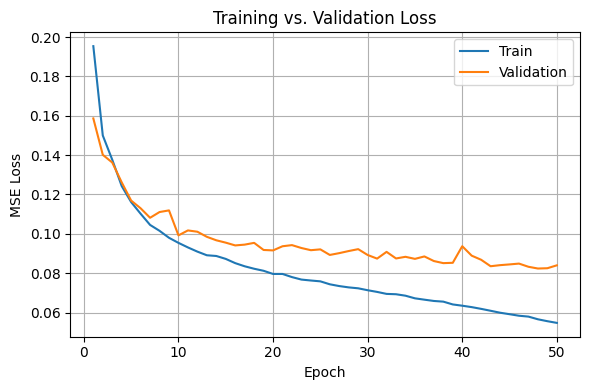

In [8]:
plt.figure(figsize=(6,4))
plt.plot(range(1, epochs+1), train_losses, label='Train')
plt.plot(range(1, epochs+1), val_losses,   label='Validation')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.title('Training vs. Validation Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [9]:
%%time
test_files = list(Path('/kaggle/input/waveform-inversion/test').glob('*.npy'))
len(test_files)

CPU times: user 292 ms, sys: 59.3 ms, total: 352 ms
Wall time: 845 ms


65818

In [10]:
x_cols = [f'x_{i}' for i in range(1, 70, 2)]
fieldnames = ['oid_ypos'] + x_cols
class TestDataset(Dataset):
    def __init__(self, test_files):
        self.test_files = test_files


    def __len__(self):
        return len(self.test_files)


    def __getitem__(self, i):
        test_file = self.test_files[i]

        return np.load(test_file), test_file.stem

ds = TestDataset(test_files)
dl = DataLoader(ds, batch_size=8, num_workers=4, pin_memory=True)

In [11]:
PATH = "/kaggle/working/best_model.pth" 
model.eval()
model.load_state_dict(torch.load(PATH, weights_only=True))

with open('submission.csv', 'wt', newline='') as csvfile:
    writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
    writer.writeheader()
    
    for inputs, oids_test in tqdm(dl, desc='test'):
        inputs = inputs.to(device)
        with torch.inference_mode():
            outputs = model(inputs)
            
        preds_norm = outputs[:, 0]
        preds_true = 0.5 * (preds_norm + 1.0) * (label_max - label_min) + label_min
        y_preds    = preds_true.cpu().numpy()
        
        for y_pred, oid_test in zip(y_preds, oids_test):
            for y_pos in range(70):
                row = dict(
                    zip(
                        x_cols,
                        [y_pred[y_pos, x_pos] for x_pos in range(1, 70, 2)]
                    )
                )
                row['oid_ypos'] = f"{oid_test}_y_{y_pos}"
            
                writer.writerow(row)

test: 100%|██████████| 8228/8228 [09:30<00:00, 14.42it/s]
